In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

torch.cuda.is_available()

True

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [3]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 512
image_width = 512

In [4]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [5]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [6]:
class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [7]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [9]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

generator_file = "saved_models/generator.pth"
discriminator_file = "saved_models/discriminator.pth"
# initialize weights if the model is not found in the paths
if os.path.exists(generator_file):
    print("Generator Found")
    generator.load_state_dict(torch.load(generator_file, map_location = device))
else:
    generator.apply(weights_init_normal)
                                         
if os.path.exists(discriminator_file):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load(discriminator_file, map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True
Generator Found
Discriminator Found


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((image_width, image_height)) # Resize the image to constant size
])

# create a dataloader
pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

dataloader = DataLoader(
    pair_image_dataloader,
    batch_size = 5,
    shuffle = True
)

val_image_dataloader = img_dataloader.ImageDataset("./data/val/old_image", "./data/val/reconstructed_image", transform)
val_dataloader = DataLoader(
    val_image_dataloader,
    batch_size = 5,
    shuffle = True
)

torch.cuda.empty_cache()

In [14]:
generator_error_file = "generator.csv"
disc_error_file = "discriminator.csv"

total_generator_epochs = 0
try: 
    with open(generator_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_generator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_generator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(generator_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()


total_discriminator_epochs = 0
try: 
    with open(disc_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_discriminator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_discriminator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(disc_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()

for epoch in range(1):
    loss_G_list = np.array([])
    loss_D_list = np.array([])
    for i, batch in tqdm(enumerate(dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # total loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()
        
        # for logging
        print(f"Generator Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
        print(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")
        
        loss_G_list = np.append(loss_G_list,  torch.linalg.norm(loss_G).item())
        loss_D_list = np.append(loss_D_list,  torch.linalg.norm(loss_D).item())
     
    # log into a file
    with open(generator_error_file, "a") as f:
        f.write(f"Generator Error, {torch.linalg.norm(loss_G).item()}, {epoch + total_generator_epochs}\n")
    with open(disc_error_file, "a") as f:
        f.write(f"Discriminator Error, {torch.linalg.norm(loss_D).item()}, {epoch + total_discriminator_epochs}\n")
        
    torch.save(generator.state_dict(), "saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
            
    torch.cuda.empty_cache()

0it [00:00, ?it/s]

CSV file found
CSV file found


1it [00:01,  1.07s/it]

Generator Error: 3.8410918712615967, epoch: 0, itr: 0
Discriminator Error: 0.022108659148216248, epoch: 0, itr: 0


2it [00:01,  1.12it/s]

Generator Error: 4.613907337188721, epoch: 0, itr: 1
Discriminator Error: 0.0026290519163012505, epoch: 0, itr: 1


3it [00:02,  1.19it/s]

Generator Error: 2.9581263065338135, epoch: 0, itr: 2
Discriminator Error: 0.028108874335885048, epoch: 0, itr: 2


4it [00:03,  1.23it/s]

Generator Error: 3.348257303237915, epoch: 0, itr: 3
Discriminator Error: 0.0011942700948566198, epoch: 0, itr: 3


5it [00:04,  1.25it/s]

Generator Error: 3.6202139854431152, epoch: 0, itr: 4
Discriminator Error: 0.0025560325011610985, epoch: 0, itr: 4


6it [00:04,  1.27it/s]

Generator Error: 4.026681423187256, epoch: 0, itr: 5
Discriminator Error: 0.0021735779009759426, epoch: 0, itr: 5


7it [00:05,  1.28it/s]

Generator Error: 3.785081386566162, epoch: 0, itr: 6
Discriminator Error: 0.0031461133621633053, epoch: 0, itr: 6


8it [00:06,  1.29it/s]

Generator Error: 4.834728717803955, epoch: 0, itr: 7
Discriminator Error: 0.000789877085480839, epoch: 0, itr: 7


9it [00:07,  1.29it/s]

Generator Error: 4.349367618560791, epoch: 0, itr: 8
Discriminator Error: 0.0017634847899898887, epoch: 0, itr: 8


10it [00:08,  1.28it/s]

Generator Error: 3.099623918533325, epoch: 0, itr: 9
Discriminator Error: 0.0003378730616532266, epoch: 0, itr: 9


11it [00:08,  1.28it/s]

Generator Error: 3.946423292160034, epoch: 0, itr: 10
Discriminator Error: 0.0050001018680632114, epoch: 0, itr: 10


12it [00:09,  1.29it/s]

Generator Error: 3.1620609760284424, epoch: 0, itr: 11
Discriminator Error: 0.004077839199453592, epoch: 0, itr: 11


13it [00:10,  1.29it/s]

Generator Error: 3.7091286182403564, epoch: 0, itr: 12
Discriminator Error: 0.00029890905716456473, epoch: 0, itr: 12


14it [00:11,  1.29it/s]

Generator Error: 3.2420310974121094, epoch: 0, itr: 13
Discriminator Error: 0.0018018418923020363, epoch: 0, itr: 13


15it [00:11,  1.29it/s]

Generator Error: 3.802990674972534, epoch: 0, itr: 14
Discriminator Error: 0.0009072653483599424, epoch: 0, itr: 14


16it [00:12,  1.29it/s]

Generator Error: 3.517655611038208, epoch: 0, itr: 15
Discriminator Error: 0.005395243410021067, epoch: 0, itr: 15


17it [00:13,  1.29it/s]

Generator Error: 3.1081223487854004, epoch: 0, itr: 16
Discriminator Error: 0.018470751121640205, epoch: 0, itr: 16


18it [00:14,  1.29it/s]

Generator Error: 3.9087250232696533, epoch: 0, itr: 17
Discriminator Error: 1.8021470168605447e-05, epoch: 0, itr: 17


19it [00:15,  1.28it/s]

Generator Error: 3.265695095062256, epoch: 0, itr: 18
Discriminator Error: 0.019052106887102127, epoch: 0, itr: 18


20it [00:15,  1.26it/s]

Generator Error: 3.289844274520874, epoch: 0, itr: 19
Discriminator Error: 0.008814736269414425, epoch: 0, itr: 19


21it [00:16,  1.27it/s]

Generator Error: 2.783965826034546, epoch: 0, itr: 20
Discriminator Error: 0.045751314610242844, epoch: 0, itr: 20


22it [00:17,  1.27it/s]

Generator Error: 3.526662826538086, epoch: 0, itr: 21
Discriminator Error: 0.0030169342644512653, epoch: 0, itr: 21


23it [00:18,  1.27it/s]

Generator Error: 3.7998733520507812, epoch: 0, itr: 22
Discriminator Error: 0.004843320697546005, epoch: 0, itr: 22


24it [00:19,  1.22it/s]

Generator Error: 4.2647199630737305, epoch: 0, itr: 23
Discriminator Error: 0.002835193183273077, epoch: 0, itr: 23


25it [00:19,  1.23it/s]

Generator Error: 3.6846296787261963, epoch: 0, itr: 24
Discriminator Error: 0.002119516022503376, epoch: 0, itr: 24


26it [00:20,  1.25it/s]

Generator Error: 3.6880722045898438, epoch: 0, itr: 25
Discriminator Error: 0.013948515057563782, epoch: 0, itr: 25


27it [00:21,  1.25it/s]

Generator Error: 2.9934747219085693, epoch: 0, itr: 26
Discriminator Error: 0.02586955949664116, epoch: 0, itr: 26


28it [00:22,  1.26it/s]

Generator Error: 3.7809927463531494, epoch: 0, itr: 27
Discriminator Error: 0.008853637613356113, epoch: 0, itr: 27


29it [00:23,  1.26it/s]

Generator Error: 4.094358921051025, epoch: 0, itr: 28
Discriminator Error: 0.0008138669654726982, epoch: 0, itr: 28


30it [00:23,  1.26it/s]

Generator Error: 3.4941608905792236, epoch: 0, itr: 29
Discriminator Error: 0.0021215856540948153, epoch: 0, itr: 29


31it [00:24,  1.27it/s]

Generator Error: 3.506356716156006, epoch: 0, itr: 30
Discriminator Error: 0.0012090688105672598, epoch: 0, itr: 30


32it [00:25,  1.27it/s]

Generator Error: 3.56341552734375, epoch: 0, itr: 31
Discriminator Error: 0.004131116904318333, epoch: 0, itr: 31


33it [00:26,  1.28it/s]

Generator Error: 3.6706812381744385, epoch: 0, itr: 32
Discriminator Error: 0.000698513409588486, epoch: 0, itr: 32


34it [00:26,  1.28it/s]

Generator Error: 3.557093381881714, epoch: 0, itr: 33
Discriminator Error: 0.0035723859909921885, epoch: 0, itr: 33


35it [00:27,  1.26it/s]

Generator Error: 3.3728015422821045, epoch: 0, itr: 34
Discriminator Error: 8.341949069290422e-06, epoch: 0, itr: 34


36it [00:28,  1.27it/s]

Generator Error: 2.8618879318237305, epoch: 0, itr: 35
Discriminator Error: 0.008080881088972092, epoch: 0, itr: 35


37it [00:29,  1.26it/s]

Generator Error: 3.271902084350586, epoch: 0, itr: 36
Discriminator Error: 0.000136604969156906, epoch: 0, itr: 36


38it [00:30,  1.25it/s]

Generator Error: 3.4007415771484375, epoch: 0, itr: 37
Discriminator Error: 4.039101258968003e-05, epoch: 0, itr: 37


39it [00:30,  1.26it/s]

Generator Error: 3.1222751140594482, epoch: 0, itr: 38
Discriminator Error: 0.0037955250591039658, epoch: 0, itr: 38


40it [00:31,  1.26it/s]

Generator Error: 3.429163694381714, epoch: 0, itr: 39
Discriminator Error: 0.0033652212005108595, epoch: 0, itr: 39


41it [00:32,  1.26it/s]

Generator Error: 4.166481018066406, epoch: 0, itr: 40
Discriminator Error: 5.327924100129167e-06, epoch: 0, itr: 40


42it [00:33,  1.26it/s]

Generator Error: 4.053878307342529, epoch: 0, itr: 41
Discriminator Error: 8.722757229406852e-06, epoch: 0, itr: 41


43it [00:34,  1.26it/s]

Generator Error: 3.91519832611084, epoch: 0, itr: 42
Discriminator Error: 6.224120443221182e-05, epoch: 0, itr: 42


44it [00:34,  1.26it/s]

Generator Error: 3.5768747329711914, epoch: 0, itr: 43
Discriminator Error: 0.0033491579815745354, epoch: 0, itr: 43


45it [00:35,  1.26it/s]

Generator Error: 3.5393452644348145, epoch: 0, itr: 44
Discriminator Error: 0.0018357326043769717, epoch: 0, itr: 44


46it [00:36,  1.26it/s]

Generator Error: 3.656609296798706, epoch: 0, itr: 45
Discriminator Error: 7.858783646952361e-05, epoch: 0, itr: 45


47it [00:37,  1.26it/s]

Generator Error: 3.1323132514953613, epoch: 0, itr: 46
Discriminator Error: 0.014641886577010155, epoch: 0, itr: 46


48it [00:38,  1.26it/s]

Generator Error: 3.4215471744537354, epoch: 0, itr: 47
Discriminator Error: 0.00037851216620765626, epoch: 0, itr: 47


49it [00:38,  1.26it/s]

Generator Error: 3.0928955078125, epoch: 0, itr: 48
Discriminator Error: 0.0022704279981553555, epoch: 0, itr: 48


50it [00:39,  1.24it/s]

Generator Error: 3.20992374420166, epoch: 0, itr: 49
Discriminator Error: 0.0003427759511396289, epoch: 0, itr: 49


51it [00:40,  1.24it/s]

Generator Error: 3.6335980892181396, epoch: 0, itr: 50
Discriminator Error: 0.004978746175765991, epoch: 0, itr: 50


52it [00:41,  1.24it/s]

Generator Error: 3.4108541011810303, epoch: 0, itr: 51
Discriminator Error: 0.004655626602470875, epoch: 0, itr: 51


53it [00:42,  1.25it/s]

Generator Error: 3.425201892852783, epoch: 0, itr: 52
Discriminator Error: 0.00031487317755818367, epoch: 0, itr: 52


54it [00:42,  1.22it/s]

Generator Error: 3.1544859409332275, epoch: 0, itr: 53
Discriminator Error: 0.0032207085750997066, epoch: 0, itr: 53


55it [00:43,  1.23it/s]

Generator Error: 4.176311016082764, epoch: 0, itr: 54
Discriminator Error: 0.0034857592545449734, epoch: 0, itr: 54


56it [00:44,  1.23it/s]

Generator Error: 3.4024863243103027, epoch: 0, itr: 55
Discriminator Error: 0.0002752767177298665, epoch: 0, itr: 55


57it [00:45,  1.24it/s]

Generator Error: 3.2043724060058594, epoch: 0, itr: 56
Discriminator Error: 7.104627002263442e-05, epoch: 0, itr: 56


58it [00:46,  1.24it/s]

Generator Error: 4.449542999267578, epoch: 0, itr: 57
Discriminator Error: 1.5738996808067895e-05, epoch: 0, itr: 57


59it [00:46,  1.24it/s]

Generator Error: 3.9174487590789795, epoch: 0, itr: 58
Discriminator Error: 0.003781538223847747, epoch: 0, itr: 58


60it [00:47,  1.25it/s]

Generator Error: 3.305924654006958, epoch: 0, itr: 59
Discriminator Error: 0.0005460866959765553, epoch: 0, itr: 59


61it [00:48,  1.24it/s]

Generator Error: 3.7611706256866455, epoch: 0, itr: 60
Discriminator Error: 0.0008436584030278027, epoch: 0, itr: 60


62it [00:49,  1.25it/s]

Generator Error: 3.6664392948150635, epoch: 0, itr: 61
Discriminator Error: 0.0009238223428837955, epoch: 0, itr: 61


63it [00:50,  1.24it/s]

Generator Error: 4.55592679977417, epoch: 0, itr: 62
Discriminator Error: 3.933842435799306e-06, epoch: 0, itr: 62


64it [00:51,  1.24it/s]

Generator Error: 3.3646769523620605, epoch: 0, itr: 63
Discriminator Error: 0.0001827176456572488, epoch: 0, itr: 63


65it [00:51,  1.22it/s]

Generator Error: 3.226471185684204, epoch: 0, itr: 64
Discriminator Error: 0.004240250680595636, epoch: 0, itr: 64


66it [00:52,  1.22it/s]

Generator Error: 3.464054584503174, epoch: 0, itr: 65
Discriminator Error: 0.00019646598957479, epoch: 0, itr: 65


67it [00:53,  1.23it/s]

Generator Error: 3.0897865295410156, epoch: 0, itr: 66
Discriminator Error: 0.005881346762180328, epoch: 0, itr: 66


68it [00:54,  1.24it/s]

Generator Error: 4.030510902404785, epoch: 0, itr: 67
Discriminator Error: 0.0015859180130064487, epoch: 0, itr: 67


69it [00:55,  1.24it/s]

Generator Error: 3.434108257293701, epoch: 0, itr: 68
Discriminator Error: 0.010270003229379654, epoch: 0, itr: 68


70it [00:55,  1.24it/s]

Generator Error: 4.264328956604004, epoch: 0, itr: 69
Discriminator Error: 0.00225661089643836, epoch: 0, itr: 69


71it [00:56,  1.25it/s]

Generator Error: 4.056727409362793, epoch: 0, itr: 70
Discriminator Error: 0.0005670377286151052, epoch: 0, itr: 70


72it [00:57,  1.25it/s]

Generator Error: 3.8017730712890625, epoch: 0, itr: 71
Discriminator Error: 0.007281700149178505, epoch: 0, itr: 71


73it [00:58,  1.25it/s]

Generator Error: 3.9080567359924316, epoch: 0, itr: 72
Discriminator Error: 0.0014725070213899016, epoch: 0, itr: 72


74it [00:59,  1.24it/s]

Generator Error: 3.7947773933410645, epoch: 0, itr: 73
Discriminator Error: 0.00045954177039675415, epoch: 0, itr: 73


75it [00:59,  1.24it/s]

Generator Error: 3.636521577835083, epoch: 0, itr: 74
Discriminator Error: 0.01129639707505703, epoch: 0, itr: 74


76it [01:00,  1.20it/s]

Generator Error: 3.623866081237793, epoch: 0, itr: 75
Discriminator Error: 0.006513527128845453, epoch: 0, itr: 75


77it [01:01,  1.21it/s]

Generator Error: 3.8099350929260254, epoch: 0, itr: 76
Discriminator Error: 0.00045788451097905636, epoch: 0, itr: 76


78it [01:02,  1.21it/s]

Generator Error: 3.9119017124176025, epoch: 0, itr: 77
Discriminator Error: 0.01766718551516533, epoch: 0, itr: 77


79it [01:03,  1.21it/s]

Generator Error: 3.496426582336426, epoch: 0, itr: 78
Discriminator Error: 0.00156259851064533, epoch: 0, itr: 78


80it [01:04,  1.22it/s]

Generator Error: 4.006659507751465, epoch: 0, itr: 79
Discriminator Error: 0.0012176032178103924, epoch: 0, itr: 79


81it [01:04,  1.23it/s]

Generator Error: 3.7750802040100098, epoch: 0, itr: 80
Discriminator Error: 0.0021159450989216566, epoch: 0, itr: 80


82it [01:05,  1.24it/s]

Generator Error: 3.878925085067749, epoch: 0, itr: 81
Discriminator Error: 0.0009518367587588727, epoch: 0, itr: 81


83it [01:06,  1.23it/s]

Generator Error: 3.2543210983276367, epoch: 0, itr: 82
Discriminator Error: 0.0017383950762450695, epoch: 0, itr: 82


84it [01:07,  1.23it/s]

Generator Error: 3.9630661010742188, epoch: 0, itr: 83
Discriminator Error: 0.019451068714261055, epoch: 0, itr: 83


85it [01:08,  1.22it/s]

Generator Error: 3.3888165950775146, epoch: 0, itr: 84
Discriminator Error: 0.11909625679254532, epoch: 0, itr: 84


86it [01:08,  1.22it/s]

Generator Error: 3.570119857788086, epoch: 0, itr: 85
Discriminator Error: 0.004058056510984898, epoch: 0, itr: 85


87it [01:09,  1.22it/s]

Generator Error: 3.1384167671203613, epoch: 0, itr: 86
Discriminator Error: 0.027781004086136818, epoch: 0, itr: 86


88it [01:10,  1.23it/s]

Generator Error: 3.5580248832702637, epoch: 0, itr: 87
Discriminator Error: 0.02402963861823082, epoch: 0, itr: 87


89it [01:11,  1.23it/s]

Generator Error: 3.436995267868042, epoch: 0, itr: 88
Discriminator Error: 0.001771248527802527, epoch: 0, itr: 88


90it [01:12,  1.22it/s]

Generator Error: 3.4794960021972656, epoch: 0, itr: 89
Discriminator Error: 0.010243421420454979, epoch: 0, itr: 89


91it [01:13,  1.23it/s]

Generator Error: 2.5903868675231934, epoch: 0, itr: 90
Discriminator Error: 0.008259695954620838, epoch: 0, itr: 90


92it [01:13,  1.24it/s]

Generator Error: 3.7299160957336426, epoch: 0, itr: 91
Discriminator Error: 0.030133426189422607, epoch: 0, itr: 91


93it [01:14,  1.24it/s]

Generator Error: 3.713538646697998, epoch: 0, itr: 92
Discriminator Error: 0.02170102298259735, epoch: 0, itr: 92


94it [01:15,  1.25it/s]

Generator Error: 3.0589582920074463, epoch: 0, itr: 93
Discriminator Error: 0.002211048034951091, epoch: 0, itr: 93


95it [01:16,  1.24it/s]

Generator Error: 4.068358421325684, epoch: 0, itr: 94
Discriminator Error: 0.0022571198642253876, epoch: 0, itr: 94


96it [01:17,  1.24it/s]

Generator Error: 4.244227886199951, epoch: 0, itr: 95
Discriminator Error: 0.001099578570574522, epoch: 0, itr: 95


97it [01:17,  1.24it/s]

Generator Error: 3.3170344829559326, epoch: 0, itr: 96
Discriminator Error: 0.0008882235852070153, epoch: 0, itr: 96


98it [01:18,  1.24it/s]

Generator Error: 3.338843584060669, epoch: 0, itr: 97
Discriminator Error: 0.00039327837293967605, epoch: 0, itr: 97


99it [01:19,  1.24it/s]

Generator Error: 3.9591012001037598, epoch: 0, itr: 98
Discriminator Error: 0.0019891206175088882, epoch: 0, itr: 98


100it [01:20,  1.24it/s]

Generator Error: 3.0191917419433594, epoch: 0, itr: 99
Discriminator Error: 0.0041032275184988976, epoch: 0, itr: 99


101it [01:21,  1.24it/s]

Generator Error: 3.97149395942688, epoch: 0, itr: 100
Discriminator Error: 0.00010018453758675605, epoch: 0, itr: 100


102it [01:21,  1.25it/s]

Generator Error: 3.1718738079071045, epoch: 0, itr: 101
Discriminator Error: 0.0005292913410812616, epoch: 0, itr: 101


103it [01:22,  1.25it/s]

Generator Error: 2.9911537170410156, epoch: 0, itr: 102
Discriminator Error: 0.006758192554116249, epoch: 0, itr: 102


104it [01:23,  1.25it/s]

Generator Error: 3.400341749191284, epoch: 0, itr: 103
Discriminator Error: 8.873615297488868e-05, epoch: 0, itr: 103


105it [01:24,  1.25it/s]

Generator Error: 4.171626567840576, epoch: 0, itr: 104
Discriminator Error: 0.0005187091883271933, epoch: 0, itr: 104


106it [01:25,  1.25it/s]

Generator Error: 2.9236435890197754, epoch: 0, itr: 105
Discriminator Error: 0.016942549496889114, epoch: 0, itr: 105


107it [01:25,  1.22it/s]

Generator Error: 3.29009747505188, epoch: 0, itr: 106
Discriminator Error: 0.008267932571470737, epoch: 0, itr: 106


108it [01:26,  1.22it/s]

Generator Error: 2.816516399383545, epoch: 0, itr: 107
Discriminator Error: 0.023694785311818123, epoch: 0, itr: 107


109it [01:27,  1.23it/s]

Generator Error: 4.006977558135986, epoch: 0, itr: 108
Discriminator Error: 0.006283111870288849, epoch: 0, itr: 108


110it [01:28,  1.24it/s]

Generator Error: 3.271944522857666, epoch: 0, itr: 109
Discriminator Error: 0.00475029181689024, epoch: 0, itr: 109


111it [01:29,  1.23it/s]

Generator Error: 3.8298089504241943, epoch: 0, itr: 110
Discriminator Error: 0.009456295520067215, epoch: 0, itr: 110


112it [01:29,  1.24it/s]

Generator Error: 3.3762502670288086, epoch: 0, itr: 111
Discriminator Error: 0.0014477282529696822, epoch: 0, itr: 111


113it [01:30,  1.24it/s]

Generator Error: 3.7951302528381348, epoch: 0, itr: 112
Discriminator Error: 5.090673948870972e-05, epoch: 0, itr: 112


114it [01:31,  1.24it/s]

Generator Error: 3.434502601623535, epoch: 0, itr: 113
Discriminator Error: 9.56654766923748e-05, epoch: 0, itr: 113


115it [01:32,  1.24it/s]

Generator Error: 4.366942882537842, epoch: 0, itr: 114
Discriminator Error: 1.7845903130364604e-05, epoch: 0, itr: 114


116it [01:33,  1.25it/s]

Generator Error: 4.1724982261657715, epoch: 0, itr: 115
Discriminator Error: 0.0027079859282821417, epoch: 0, itr: 115


117it [01:33,  1.25it/s]

Generator Error: 3.131767749786377, epoch: 0, itr: 116
Discriminator Error: 0.0027118592988699675, epoch: 0, itr: 116


118it [01:34,  1.25it/s]

Generator Error: 3.134456157684326, epoch: 0, itr: 117
Discriminator Error: 0.0008607943309471011, epoch: 0, itr: 117


119it [01:35,  1.25it/s]

Generator Error: 3.5986335277557373, epoch: 0, itr: 118
Discriminator Error: 0.003688500728458166, epoch: 0, itr: 118


120it [01:36,  1.24it/s]

Generator Error: 2.9056196212768555, epoch: 0, itr: 119
Discriminator Error: 0.0047720554284751415, epoch: 0, itr: 119


121it [01:37,  1.25it/s]

Generator Error: 3.0604701042175293, epoch: 0, itr: 120
Discriminator Error: 0.01975555345416069, epoch: 0, itr: 120


122it [01:37,  1.24it/s]

Generator Error: 3.6223065853118896, epoch: 0, itr: 121
Discriminator Error: 2.3886726921773516e-05, epoch: 0, itr: 121


123it [01:38,  1.24it/s]

Generator Error: 3.7229769229888916, epoch: 0, itr: 122
Discriminator Error: 0.0006401286227628589, epoch: 0, itr: 122


124it [01:39,  1.25it/s]

Generator Error: 4.104735374450684, epoch: 0, itr: 123
Discriminator Error: 0.007339932955801487, epoch: 0, itr: 123


125it [01:40,  1.25it/s]

Generator Error: 3.1374573707580566, epoch: 0, itr: 124
Discriminator Error: 0.022044815123081207, epoch: 0, itr: 124


126it [01:41,  1.25it/s]

Generator Error: 3.6472442150115967, epoch: 0, itr: 125
Discriminator Error: 0.001106161274947226, epoch: 0, itr: 125


127it [01:41,  1.24it/s]

Generator Error: 3.201021432876587, epoch: 0, itr: 126
Discriminator Error: 0.055062174797058105, epoch: 0, itr: 126


128it [01:42,  1.24it/s]

Generator Error: 3.4492712020874023, epoch: 0, itr: 127
Discriminator Error: 0.0024011917412281036, epoch: 0, itr: 127


129it [01:43,  1.23it/s]

Generator Error: 3.8205208778381348, epoch: 0, itr: 128
Discriminator Error: 0.04502936825156212, epoch: 0, itr: 128


130it [01:44,  1.24it/s]

Generator Error: 3.6256449222564697, epoch: 0, itr: 129
Discriminator Error: 0.012167553417384624, epoch: 0, itr: 129


131it [01:45,  1.24it/s]

Generator Error: 3.66382098197937, epoch: 0, itr: 130
Discriminator Error: 0.0004994961200281978, epoch: 0, itr: 130


132it [01:46,  1.25it/s]

Generator Error: 4.335423946380615, epoch: 0, itr: 131
Discriminator Error: 0.06604737788438797, epoch: 0, itr: 131


133it [01:46,  1.24it/s]

Generator Error: 3.56921648979187, epoch: 0, itr: 132
Discriminator Error: 0.022228721529245377, epoch: 0, itr: 132


134it [01:47,  1.24it/s]

Generator Error: 3.3069870471954346, epoch: 0, itr: 133
Discriminator Error: 0.02513726055622101, epoch: 0, itr: 133


135it [01:48,  1.22it/s]

Generator Error: 3.4047515392303467, epoch: 0, itr: 134
Discriminator Error: 0.02616623416543007, epoch: 0, itr: 134


136it [01:49,  1.22it/s]

Generator Error: 3.1576731204986572, epoch: 0, itr: 135
Discriminator Error: 0.006100381258875132, epoch: 0, itr: 135


137it [01:50,  1.22it/s]

Generator Error: 2.7948808670043945, epoch: 0, itr: 136
Discriminator Error: 0.06849364936351776, epoch: 0, itr: 136


138it [01:50,  1.23it/s]

Generator Error: 3.942389726638794, epoch: 0, itr: 137
Discriminator Error: 0.0009591327980160713, epoch: 0, itr: 137


139it [01:51,  1.23it/s]

Generator Error: 3.633065938949585, epoch: 0, itr: 138
Discriminator Error: 0.08036597818136215, epoch: 0, itr: 138


140it [01:52,  1.23it/s]

Generator Error: 3.9388551712036133, epoch: 0, itr: 139
Discriminator Error: 0.0022743595764040947, epoch: 0, itr: 139


141it [01:53,  1.24it/s]

Generator Error: 3.1600236892700195, epoch: 0, itr: 140
Discriminator Error: 0.021267849951982498, epoch: 0, itr: 140


142it [01:54,  1.24it/s]

Generator Error: 4.166172027587891, epoch: 0, itr: 141
Discriminator Error: 0.011333517730236053, epoch: 0, itr: 141


143it [01:54,  1.24it/s]

Generator Error: 4.073613166809082, epoch: 0, itr: 142
Discriminator Error: 0.00020080115064047277, epoch: 0, itr: 142


144it [01:55,  1.23it/s]

Generator Error: 3.728501081466675, epoch: 0, itr: 143
Discriminator Error: 0.0232679583132267, epoch: 0, itr: 143


145it [01:56,  1.23it/s]

Generator Error: 3.6003832817077637, epoch: 0, itr: 144
Discriminator Error: 0.009545814245939255, epoch: 0, itr: 144


146it [01:57,  1.24it/s]

Generator Error: 3.182090997695923, epoch: 0, itr: 145
Discriminator Error: 0.0018646408570930362, epoch: 0, itr: 145


147it [01:58,  1.24it/s]

Generator Error: 3.3020036220550537, epoch: 0, itr: 146
Discriminator Error: 0.0034203294198960066, epoch: 0, itr: 146


148it [01:58,  1.24it/s]

Generator Error: 3.1308155059814453, epoch: 0, itr: 147
Discriminator Error: 0.012532178312540054, epoch: 0, itr: 147


149it [01:59,  1.24it/s]

Generator Error: 5.051475524902344, epoch: 0, itr: 148
Discriminator Error: 0.00022481083578895777, epoch: 0, itr: 148


150it [02:00,  1.24it/s]

Generator Error: 3.5878052711486816, epoch: 0, itr: 149
Discriminator Error: 0.00012352265184745193, epoch: 0, itr: 149


151it [02:01,  1.24it/s]

Generator Error: 3.1806883811950684, epoch: 0, itr: 150
Discriminator Error: 0.007024084217846394, epoch: 0, itr: 150


152it [02:02,  1.24it/s]

Generator Error: 3.924302577972412, epoch: 0, itr: 151
Discriminator Error: 0.0035554026253521442, epoch: 0, itr: 151


153it [02:03,  1.23it/s]

Generator Error: 3.0554215908050537, epoch: 0, itr: 152
Discriminator Error: 0.043785396963357925, epoch: 0, itr: 152


154it [02:03,  1.24it/s]

Generator Error: 2.7835845947265625, epoch: 0, itr: 153
Discriminator Error: 0.02295149862766266, epoch: 0, itr: 153


155it [02:04,  1.24it/s]

Generator Error: 3.674668788909912, epoch: 0, itr: 154
Discriminator Error: 0.0026852660812437534, epoch: 0, itr: 154


156it [02:05,  1.24it/s]

Generator Error: 3.392144203186035, epoch: 0, itr: 155
Discriminator Error: 0.00015492882812395692, epoch: 0, itr: 155


157it [02:06,  1.24it/s]

Generator Error: 3.2508273124694824, epoch: 0, itr: 156
Discriminator Error: 0.00445144809782505, epoch: 0, itr: 156


158it [02:07,  1.24it/s]

Generator Error: 3.811955451965332, epoch: 0, itr: 157
Discriminator Error: 0.004389135167002678, epoch: 0, itr: 157


159it [02:07,  1.24it/s]

Generator Error: 2.9593842029571533, epoch: 0, itr: 158
Discriminator Error: 0.004574592225253582, epoch: 0, itr: 158


160it [02:08,  1.21it/s]

Generator Error: 3.0807528495788574, epoch: 0, itr: 159
Discriminator Error: 0.006106517277657986, epoch: 0, itr: 159


161it [02:09,  1.21it/s]

Generator Error: 3.2649049758911133, epoch: 0, itr: 160
Discriminator Error: 0.012197703123092651, epoch: 0, itr: 160


162it [02:10,  1.22it/s]

Generator Error: 3.3842034339904785, epoch: 0, itr: 161
Discriminator Error: 0.00013900290650781244, epoch: 0, itr: 161


163it [02:11,  1.22it/s]

Generator Error: 3.6043894290924072, epoch: 0, itr: 162
Discriminator Error: 0.00030310885631479323, epoch: 0, itr: 162


164it [02:11,  1.22it/s]

Generator Error: 3.322439193725586, epoch: 0, itr: 163
Discriminator Error: 0.01137838326394558, epoch: 0, itr: 163


165it [02:12,  1.23it/s]

Generator Error: 3.0664045810699463, epoch: 0, itr: 164
Discriminator Error: 0.0002934904186986387, epoch: 0, itr: 164


166it [02:13,  1.23it/s]

Generator Error: 4.075546741485596, epoch: 0, itr: 165
Discriminator Error: 0.00015274740871973336, epoch: 0, itr: 165


167it [02:14,  1.23it/s]

Generator Error: 4.250363826751709, epoch: 0, itr: 166
Discriminator Error: 0.00013391068205237389, epoch: 0, itr: 166


168it [02:15,  1.23it/s]

Generator Error: 3.5188283920288086, epoch: 0, itr: 167
Discriminator Error: 0.00032058474607765675, epoch: 0, itr: 167


169it [02:16,  1.23it/s]

Generator Error: 4.295299053192139, epoch: 0, itr: 168
Discriminator Error: 0.0009682592353783548, epoch: 0, itr: 168


170it [02:16,  1.19it/s]

Generator Error: 2.6318721771240234, epoch: 0, itr: 169
Discriminator Error: 0.008944275788962841, epoch: 0, itr: 169


171it [02:17,  1.20it/s]

Generator Error: 4.193147659301758, epoch: 0, itr: 170
Discriminator Error: 0.018315164372324944, epoch: 0, itr: 170


172it [02:18,  1.21it/s]

Generator Error: 3.7143945693969727, epoch: 0, itr: 171
Discriminator Error: 0.0017044536070898175, epoch: 0, itr: 171


173it [02:19,  1.21it/s]

Generator Error: 3.730879306793213, epoch: 0, itr: 172
Discriminator Error: 0.003986092749983072, epoch: 0, itr: 172


174it [02:20,  1.22it/s]

Generator Error: 2.8043718338012695, epoch: 0, itr: 173
Discriminator Error: 0.0004288472409825772, epoch: 0, itr: 173


175it [02:21,  1.22it/s]

Generator Error: 2.9587600231170654, epoch: 0, itr: 174
Discriminator Error: 0.006416718941181898, epoch: 0, itr: 174


176it [02:21,  1.23it/s]

Generator Error: 2.8987138271331787, epoch: 0, itr: 175
Discriminator Error: 0.03632817044854164, epoch: 0, itr: 175


177it [02:22,  1.23it/s]

Generator Error: 3.344081163406372, epoch: 0, itr: 176
Discriminator Error: 0.0004199286049697548, epoch: 0, itr: 176


178it [02:23,  1.23it/s]

Generator Error: 3.3876001834869385, epoch: 0, itr: 177
Discriminator Error: 0.002024674555286765, epoch: 0, itr: 177


179it [02:24,  1.14it/s]

Generator Error: 3.67686128616333, epoch: 0, itr: 178
Discriminator Error: 0.028213661164045334, epoch: 0, itr: 178


180it [02:25,  1.16it/s]

Generator Error: 3.1039040088653564, epoch: 0, itr: 179
Discriminator Error: 0.007682788651436567, epoch: 0, itr: 179


181it [02:26,  1.15it/s]

Generator Error: 2.732820510864258, epoch: 0, itr: 180
Discriminator Error: 0.15201258659362793, epoch: 0, itr: 180


182it [02:27,  1.17it/s]

Generator Error: 3.858484983444214, epoch: 0, itr: 181
Discriminator Error: 0.08703776448965073, epoch: 0, itr: 181


183it [02:27,  1.19it/s]

Generator Error: 4.643876552581787, epoch: 0, itr: 182
Discriminator Error: 4.671483475249261e-05, epoch: 0, itr: 182


184it [02:28,  1.20it/s]

Generator Error: 4.102040767669678, epoch: 0, itr: 183
Discriminator Error: 0.0025323601439595222, epoch: 0, itr: 183


185it [02:29,  1.21it/s]

Generator Error: 3.447176456451416, epoch: 0, itr: 184
Discriminator Error: 0.0036764584947377443, epoch: 0, itr: 184


186it [02:30,  1.22it/s]

Generator Error: 3.3193392753601074, epoch: 0, itr: 185
Discriminator Error: 0.011125276796519756, epoch: 0, itr: 185


187it [02:31,  1.23it/s]

Generator Error: 4.410068035125732, epoch: 0, itr: 186
Discriminator Error: 0.00013607298023998737, epoch: 0, itr: 186


188it [02:31,  1.23it/s]

Generator Error: 3.3666586875915527, epoch: 0, itr: 187
Discriminator Error: 0.06278195977210999, epoch: 0, itr: 187


189it [02:32,  1.24it/s]

Generator Error: 4.328670501708984, epoch: 0, itr: 188
Discriminator Error: 0.0280932504683733, epoch: 0, itr: 188


190it [02:33,  1.24it/s]

Generator Error: 2.9801502227783203, epoch: 0, itr: 189
Discriminator Error: 0.02357369102537632, epoch: 0, itr: 189


191it [02:34,  1.24it/s]

Generator Error: 3.344698667526245, epoch: 0, itr: 190
Discriminator Error: 0.002328735077753663, epoch: 0, itr: 190


192it [02:35,  1.21it/s]

Generator Error: 3.56630802154541, epoch: 0, itr: 191
Discriminator Error: 0.003687877906486392, epoch: 0, itr: 191


193it [02:35,  1.21it/s]

Generator Error: 4.175522804260254, epoch: 0, itr: 192
Discriminator Error: 4.650641494663432e-05, epoch: 0, itr: 192


194it [02:36,  1.22it/s]

Generator Error: 2.7491588592529297, epoch: 0, itr: 193
Discriminator Error: 0.06733612716197968, epoch: 0, itr: 193


195it [02:37,  1.23it/s]

Generator Error: 3.247105836868286, epoch: 0, itr: 194
Discriminator Error: 0.047322630882263184, epoch: 0, itr: 194


196it [02:38,  1.23it/s]

Generator Error: 4.160645008087158, epoch: 0, itr: 195
Discriminator Error: 6.919378938619047e-05, epoch: 0, itr: 195


197it [02:39,  1.23it/s]

Generator Error: 3.3796744346618652, epoch: 0, itr: 196
Discriminator Error: 0.006490276660770178, epoch: 0, itr: 196


198it [02:40,  1.22it/s]

Generator Error: 3.4754679203033447, epoch: 0, itr: 197
Discriminator Error: 0.0072158388793468475, epoch: 0, itr: 197


199it [02:40,  1.22it/s]

Generator Error: 2.854215621948242, epoch: 0, itr: 198
Discriminator Error: 0.03257305920124054, epoch: 0, itr: 198


200it [02:41,  1.24it/s]

Generator Error: 3.446960926055908, epoch: 0, itr: 199
Discriminator Error: 0.006260134279727936, epoch: 0, itr: 199


In [22]:
from scipy.linalg import sqrtm
def fid(img1_vec, img2_vec) -> float:
    #calculate mean
    mu1, C1 = img1_vec.mean(axis = 0), np.cov(img1_vec, rowvar = False)
    mu2, C2 = img2_vec.mean(axis = 0), np.cov(img2_vec, rowvar = False)

    # sum of squared difference
    msdiff = np.sum((mu1 - mu2) ** 2)

    # sqrt of products
    product_covariance = sqrtm(C1.dot(C2)) 
    if np.iscomplexobj(product_covariance):
        product_covariance = product_covariance.real

    sqrt_product_covariance = np.trace(C1 + C2 - 2 * product_covariance)
    #return the result
    return msdiff + sqrt_product_covariance

In [24]:
def calculate_fid(model, images_1, images_2):
    preprocess = transforms.Compose([
        transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.ToTensor(),
    ])
    images_1 = preprocess(images_1)
    images_2 = preprocess(images_2)
    img1_vec = model(preprocess(images_1)).detach().cpu().numpy()
    img2_vec = model(preprocess(images_2)).detach().cpu().numpy()
    return fid(img1_vec, img2_vec)

preprocess = transforms.Compose([
        transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.ToTensor(),
    ])
dataloader_list = list(iter(dataloader))
images_1 = preprocess(generator(dataloader_list[0]['A'].to(device)).detach().cpu())
images_2 = preprocess(dataloader_list[0]['B'])
img1_vec = model(preprocess(images_1)).detach().cpu().numpy()
img2_vec = model(preprocess(images_2)).detach().cpu().numpy()


In [25]:
fid(np.transpose(img1_vec), np.transpose(img2_vec))

0.036830530347769175

In [23]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True, progress=False)
model.eval()

Using cache found in C:\Users\rupes/.cache\torch\hub\pytorch_vision_v0.10.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

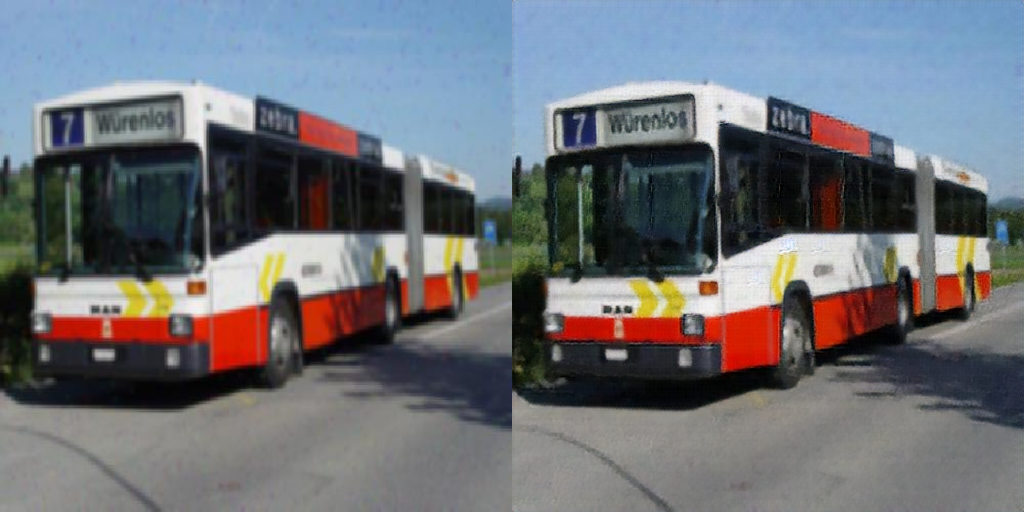

In [32]:
test_image_index = 4
test_image_index_2 = 0
dataloader_list = list(iter(dataloader))
output_image = image_manipulation.np_to_pil(
    generator(dataloader_list[test_image_index]['A'][test_image_index].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

original_image = image_manipulation.np_to_pil(
    dataloader_list[test_image_index]['A'][test_image_index].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512 * 2, 512))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (512, 0))

new_image

In [35]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
])
fid(model(preprocess(new_image).unsqueeze(0)).detach().cpu().numpy(), model(preprocess(original_image).unsqueeze(0)).detach().cpu().numpy())

ValueError: diag requires an array of at least two dimensions

In [47]:
import requests
from io import BytesIO

response = requests.get("https://pbs.twimg.com/media/FJ8XOTbagAcpzcm?format=png&name=small")
original_image = Image.open(BytesIO(response.content))
output_image = image_manipulation.np_to_pil(
    generator(transform(original_image).unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

new_image = Image.new(output_image.mode, (512, 256))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (256, 0))

In [31]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [12]:
# count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
